In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
file_path = '/content/mean_SD_by_country_by_month.csv'
df = pd.read_csv(file_path)
df['Month'] = pd.to_datetime(df['Month'])
df.head()

,country,Month,mean_SD
0,AUSTRIA,2000-01-01,8
1,AUSTRIA,2000-02-01,0
2,AUSTRIA,2000-03-01,0
3,AUSTRIA,2000-04-01,0
4,AUSTRIA,2000-05-01,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4762 entries, 0 to 4761
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   country  4762 non-null   object        
 1   Month    4762 non-null   datetime64[ns]
 2   mean_SD  4762 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 111.7+ KB


In [4]:
df.describe()

,Month,mean_SD
count,4762,4762.000000
mean,2012-06-28 11:50:37.547249152,1.956531
min,2000-01-01 00:00:00,0.000000
25%,2006-03-01 00:00:00,0.000000
50%,2012-07-01 00:00:00,0.000000
75%,2018-11-01 00:00:00,1.000000
max,2025-01-01 00:00:00,51.000000
std,NaN,5.810456


In [5]:
df['country'].nunique()

16

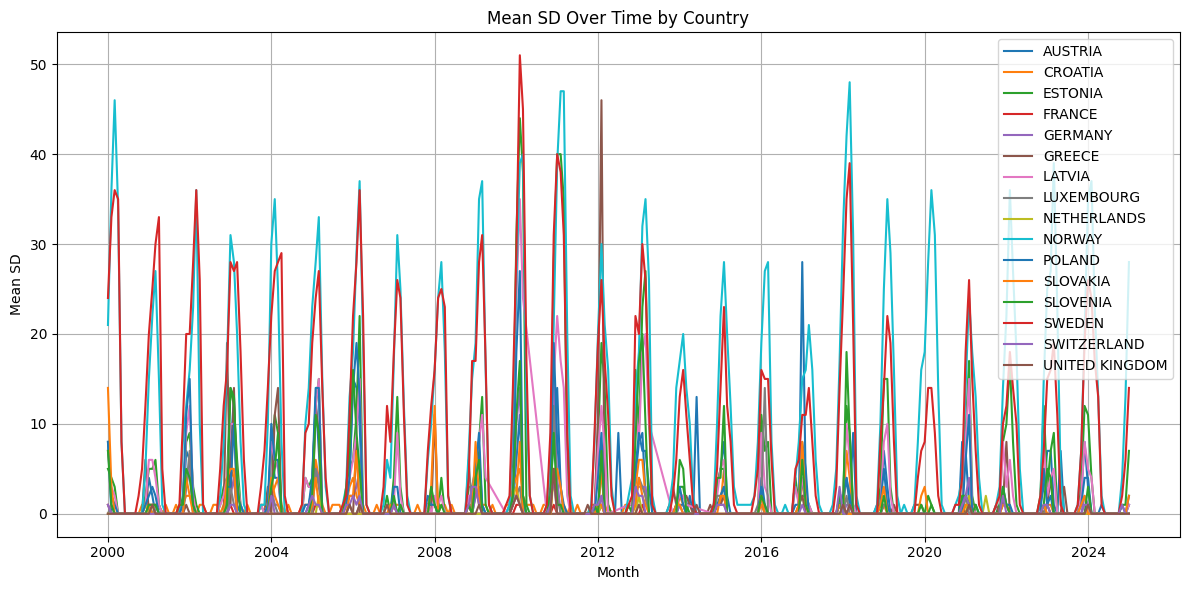

In [6]:
plt.figure(figsize=(12, 6))
for country in df['country'].unique():
    country_data = df[df['country'] == country]
    plt.plot(country_data['Month'], country_data['mean_SD'], label=country)

plt.title('Mean SD Over Time by Country')
plt.xlabel('Month')
plt.ylabel('Mean SD')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
fig = px.line(
    df,
    x='Month',
    y='mean_SD',
    color='country',
    title='Mean SD by Country Over Time',
    labels={'Month', 'mean_SD', 'country'},
    markers=True,
    template='plotly_white')

fig.update_layout(
    hovermode='x unified',
    legend_title_text='Country',
    font=dict(size=14),
    title_x=0.5)

fig.show()

In [8]:
countries = sorted(df['country'].unique())
n_cols = 4
n_rows = -(-len(countries) // n_cols)

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    shared_xaxes=False,
    subplot_titles=countries,
    vertical_spacing=0.08
)

for i, country in enumerate(countries):
    row = i // n_cols + 1
    col = i % n_cols + 1

    country_df = df[df['country'] == country]
    max_idx = country_df['mean_SD'].idxmax()
    peak_x = country_df.loc[max_idx, 'Month']
    peak_y = country_df.loc[max_idx, 'mean_SD']

    fig.add_trace(
        go.Scatter(
            x=country_df['Month'],
            y=country_df['mean_SD'],
            mode='lines',
            name=country,
            line=dict(color='blue'),
            showlegend=False
        ),
        row=row,
        col=col)

    fig.add_trace(
        go.Scatter(
            x=[peak_x],
            y=[peak_y],
            mode='markers+text',
            marker=dict(color='red', size=6),
            text=['Peak'],
            textposition='top center',
            showlegend=False
        ),
        row=row,
        col=col)

fig.update_layout(
    height=300 * n_rows,
    width=1200,
    title_text="Mean SD by Country Over Time",
    title_x=0.5,
    template='plotly_white',
    font=dict(size=12),
    margin=dict(t=60, b=40))

fig.show()

In [13]:
df = pd.read_csv("mean_SD_by_country_by_month.csv")
df['Month'] = pd.to_datetime(df['Month'])

country_mean = df.groupby('country')['mean_SD'].mean()

quantiles = country_mean.quantile([0.33, 0.66])
bins = pd.cut(country_mean, bins=[-float('inf'), quantiles[0.33], quantiles[0.66], float('inf')],
              labels=['Low', 'Medium', 'High'])

group_map = bins.to_dict()
df['mean_SD_group'] = df['country'].map(group_map)

df_clean = df.dropna(subset=['mean_SD_group'])

fig = px.line(
    df_clean,
    x="Month",
    y="mean_SD",
    color="country",
    facet_row="mean_SD_group",
    title="Trend of Mean SD Grouped by Country Activity Level",
    labels={"mean_SD": "Mean SD", "Month": "Date"},
    height=900,
    facet_row_spacing=0.07)

fig.update_layout(
    title_x=0.5,
    showlegend=False,
    template="plotly_white",
    font=dict(size=12)
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()

In [17]:
df = pd.read_csv("mean_SD_by_country_by_month.csv")
df['Month'] = pd.to_datetime(df['Month'])
df['Year'] = df['Month'].dt.year
df['Month_Num'] = df['Month'].dt.month
df['Month_Name'] = df['Month'].dt.strftime('%b')

winter_months = {'Dec': 12, 'Jan': 1, 'Feb': 2}
df = df[df['Month_Num'].isin(winter_months.values())]

top_countries = df.groupby('country')['mean_SD'].mean().sort_values(ascending=False).head(6).index

years_sorted = sorted(df['Year'].unique())
year_to_angle = {year: i * (360 / len(years_sorted)) for i, year in enumerate(years_sorted)}
angle_to_year = {v: k for k, v in year_to_angle.items()}

fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'polar'}] * 3],
    subplot_titles=["December", "January", "February"]
)

month_name_to_col = {'Dec': 1, 'Jan': 2, 'Feb': 3}

for country in top_countries:
    for month_name, col in month_name_to_col.items():
        subset = df[(df['country'] == country) & (df['Month_Name'] == month_name)]
        if not subset.empty:
            theta = subset['Year'].map(year_to_angle)
            r = subset['mean_SD']

            fig.add_trace(
                go.Scatterpolar(
                    r=r,
                    theta=theta,
                    mode='lines+markers',
                    name=country if col == 1 else None,
                    line=dict(width=2),
                    opacity=0.7,
                    showlegend=(col == 1)
                ),
                row=1, col=col
            )

tickvals = list(year_to_angle.values())
ticktext = list(year_to_angle.keys())

for i in range(1, 4):
    fig.update_layout(**{
        f'polar{i if i > 1 else ""}': dict(
            angularaxis=dict(
                tickmode='array',
                tickvals=tickvals,
                ticktext=[str(year) for year in ticktext],
                direction="clockwise",
                rotation=90
            ),
            radialaxis=dict(visible=True)
        )
    })

fig.update_layout(
    title="Mean SD by Country by Top Countries and Winter Months",
    title_x=0.5,
    height=600,
    template='plotly_white'
)

fig.show()

In [18]:
df = pd.read_csv("/content/mean_SD_by_country_by_month.csv")
df['Month'] = pd.to_datetime(df['Month'])
df['Year'] = df['Month'].dt.year
df['Month_Name'] = df['Month'].dt.strftime('%b')
df['mean_SD2'] = df['mean_SD']

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['Month_Name'] = pd.Categorical(df['Month_Name'], categories=month_order, ordered=True)
df['YearMonth'] = df['Year'].astype(str) + ' ' + df['Month_Name'].astype(str)

fig = px.scatter(
    df,
    x='YearMonth',
    y='mean_SD',
    size='mean_SD',
    color='country',
    hover_name='country',
    title='Mean SD by Country Over Time',
    height=1000,
    template='plotly_white',
    size_max=50
)

fig.update_layout(
    yaxis=dict(categoryorder='array', categoryarray=sorted(df['YearMonth'].unique(), reverse=True)),
    xaxis_title='Mean SD',
    yaxis_title='Month and Year',
    title_x=0.5
)

fig.show()

In [20]:
df = pd.read_csv("mean_SD_by_country_by_month.csv")
df['Month'] = pd.to_datetime(df['Month'])
df['Year'] = df['Month'].dt.year
df['Month_Name'] = df['Month'].dt.strftime('%b')
df['mean_SD_scaled'] = df['mean_SD']

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['Month_Name'] = pd.Categorical(df['Month_Name'], categories=month_order, ordered=True)

fig = px.scatter(
    df,
    x='Month_Name',
    y='mean_SD',
    size='mean_SD_scaled',
    color='country',
    facet_col='Year',
    facet_col_wrap=4,
    height=900,
    title='Mean SD by Country Over Time',
    template='plotly_white',
    category_orders={'Month_Name': month_order},
        labels={
        'Month_Name': 'Month',
        'mean_SD': 'SD',
        'country': 'Country'
    }
)

fig.show()

In [25]:
df = pd.read_csv("mean_SD_by_country_by_month.csv")
df['Month'] = pd.to_datetime(df['Month'])
df['Year'] = df['Month'].dt.year
df['Month_Name'] = df['Month'].dt.strftime('%b')
df['mean_SD_scaled'] = df['mean_SD']

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['Month_Name'] = pd.Categorical(df['Month_Name'], categories=month_order, ordered=True)

fig = px.scatter(
    df,
    x='Month_Name',
    y='mean_SD',
    size='mean_SD_scaled',
    color='country',
    animation_frame='Year',
    title='Mean SD by Country Over Time',
    height=700,
    template='plotly_white',
    category_orders={'Month_Name': month_order},
    labels={
        'Month_Name': 'Month',
        'mean_SD': 'Mean SD',
        'country': 'Country',
        'Year': 'Year'
    }
)

fig.update_traces(
    marker=dict(
        opacity=0.7,
        line=dict(width=0)
    ),
    selector=dict(mode='markers')
)

for trace in fig.data:
    if 'legendgroup' in trace:
        trace.marker.size = 12

fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Mean Snow Depth',
    title_x=0.5,
    legend_title='Country'
)

fig.show()

In [39]:
df = pd.read_csv("mean_SD_by_country_by_month.csv")
df['Month'] = pd.to_datetime(df['Month'])
df['Year'] = df['Month'].dt.year
df['Month_Name'] = df['Month'].dt.strftime('%b')

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['Month_Name'] = pd.Categorical(df['Month_Name'], categories=month_order, ordered=True)

years = sorted(df['Year'].unique())
countries = df['country'].unique()

fig = go.Figure()

first_year = years[0]
for country in countries:
    sub_df = df[(df['Year'] == first_year) & (df['country'] == country)]
    fig.add_trace(go.Scatter(
        x=sub_df['Month_Name'],
        y=sub_df['mean_SD'],
        mode='lines',
        name=country,
        line=dict(width=2),
        opacity=0.1,
        fill='tozeroy'
    ))

frames = []
for year in years:
    frame_data = []
    for country in countries:
        sub_df = df[(df['Year'] == year) & (df['country'] == country)]
        frame_data.append(go.Scatter(
            x=sub_df['Month_Name'],
            y=sub_df['mean_SD'],
            mode='lines',
            name=country,
            line=dict(width=2),
            opacity=0.1,
            fill='tozeroy'
        ))
    frames.append(go.Frame(data=frame_data, name=str(year)))

fig.frames = frames
fig.update_layout(
    title='Mean SD by Country Over Time',
    xaxis_title='Month',
    yaxis_title='Mean Snow Depth',
    template='plotly_white',
    height=750,
    title_x=0.5,
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        x=0.05,
        y=-0.1,
        buttons=[dict(
            label='▶ Play',
            method='animate',
            args=[None, dict(
                frame=dict(duration=900, redraw=True),
                fromcurrent=True,
                transition=dict(duration=400, easing='cubic-in-out'),
                mode='immediate'
            )]
        )]
    )],
    sliders=[dict(
        steps=[dict(method='animate',
                    args=[[str(year)],
                          dict(mode='immediate',
                               frame=dict(duration=800, redraw=True),
                               transition=dict(duration=5))],
                    label=str(year)) for year in years],
        transition=dict(duration=0),
        x=0.1,
        xanchor='left',
        y=0,
        yanchor='top'
    )]
)

fig.show()

In [24]:
df = pd.read_csv("mean_SD_by_country_by_month.csv")
df['Month'] = pd.to_datetime(df['Month'])
df['Year'] = df['Month'].dt.year
df['Month_Num'] = df['Month'].dt.month

years = sorted(df['Year'].unique())
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

vertical_spacing = 100

fig = go.Figure()

for i, year in enumerate(years):
    y_offset = i * vertical_spacing
    sub_df = df[df['Year'] == year]

    for country in sub_df['country'].unique():
        c_df = sub_df[sub_df['country'] == country]
        y_vals = c_df['mean_SD'] * 2 + y_offset
        x_vals = c_df['Month_Num']
        sizes = c_df['mean_SD']

        fig.add_trace(go.Scatter(
            x=x_vals,
            y=y_vals,
            mode='markers',
            marker=dict(
                size=sizes,
                sizemode='diameter',
                opacity=0.6,
                line=dict(width=0)
            ),
            name=country if i == 0 else None,
            legendgroup=country,
            showlegend=(i == 0),
            hovertemplate=(
                f"<b>{country}</b><br>"
                "Month: %{x}<br>"
                f"Year: {year}<br>"
                "Mean SD: %{marker.size:.2f}<extra></extra>"
            )
        ))

fig.update_traces(
    selector=dict(mode='markers', showlegend=True),
    marker=dict(symbol='circle', size=12)
)

fig.update_layout(
    title='Mean SD by Country Over Time',
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(1, 13)),
        ticktext=month_labels,
        title='Month'
    ),
    yaxis=dict(
        title='Mean SD per Year',
        tickmode='array',
        tickvals=[i * vertical_spacing for i in range(len(years))],
        ticktext=[str(year) for year in years]
    ),
    height=vertical_spacing * len(years) + 200,
    template='plotly_white',
    showlegend=True,
    title_x=0.5
)

fig.show()